# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score

from drive.MyDrive.Kaggle.Clustering_072022.src.functions import *

In [ ]:
PATH = 'drive/MyDrive/Kaggle/Clustering_072022'
data = pd.read_csv(PATH+'/src/data.csv', index_col='id')

# Scaling data and seperating groups

In [ ]:
scaled = pd.DataFrame(StandardScaler().fit_transform(data), columns=data.columns)

cat_cols = data.columns[data.dtypes=='int']
num_cols = data.columns[data.dtypes=='float']
cat_cols, num_cols

(Index(['f_07', 'f_08', 'f_09', 'f_10', 'f_11', 'f_12', 'f_13'], dtype='object'),
 Index(['f_00', 'f_01', 'f_02', 'f_03', 'f_04', 'f_05', 'f_06', 'f_14', 'f_15',
        'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_22', 'f_23', 'f_24',
        'f_25', 'f_26', 'f_27', 'f_28'],
       dtype='object'))

# Creating and applying the Gaussian Mixture Model
- The results and metrics are saved for each and made into a dataframe

In [ ]:
%%time
# Fit several models with different numbers of components
components_min, components_max = 9, 15

# result_list = []
for n_components in range(components_min, components_max):
    for seed in range(10):
        gm = GaussianMixture(n_components=n_components, random_state=seed, verbose=0, n_init=1)
        y = gm.fit_predict(scaled)
        bic = gm.bic(scaled)
        aic = gm.aic(scaled)
        print(f"{n_components:2} {bic:16.5f} {aic:16.5f}")
        result_list.append((n_components, seed, bic, aic, y, gm))

results = pd.DataFrame(result_list, columns=['n_components', 'seed', 'bic', 'aic', 'y', 'gm'])
results = results.set_index(['n_components', 'seed'])

 9    7818504.54278    7778786.99077
 9    7818144.51358    7778426.96156
 9    7815962.33691    7776244.78489
 9    7815259.98465    7775542.43263
 9    7819578.56276    7779861.01075
 9    7819118.77696    7779401.22494
 9    7817196.38633    7777478.83432
 9    7817164.04493    7777446.49291
 9    7817159.23242    7777441.68040
 9    7816073.51078    7776355.95877
10    7816488.05505    7772356.38694
10    7814339.38984    7770207.72174
10    7814486.38282    7770354.71472
10    7813418.61104    7769286.94294
10    7816460.39008    7772328.72198
10    7818180.41117    7774048.74307
10    7817875.93518    7773744.26708
10    7816802.41420    7772670.74610
10    7816647.30733    7772515.63923
10    7818200.08085    7774068.41274
11    7817198.84878    7768653.06460
11    7816545.43522    7767999.65104
11    7815311.32388    7766765.53970
11    7793466.13026    7744920.34608
11    7813882.86835    7765337.08417
11    7794218.94979    7745673.16561
11    7817054.36046    7768508.57628
1

# Comparison of Clusters

## Function definition

In [ ]:
def compare(y1, y2, title=''):
    """ This functions shows the adjusted rand score of two clusters and visualized them """
    ars = adjusted_rand_score(y1, y2)

    n1 = y1.max() + 1
    n2 = y2.max() + 1
    argsort = np.argsort(y1*100 + y2) if n1 >= n2 else np.argsort(y2*100 + y1)
    plt.figure(figsize=(16, 1))
    for i in range(6, 11):
        plt.scatter(np.arange(len(y1)), np.full_like(y1, i), c=y1[argsort], s=1, cmap='tab10')
    
    for i in range(5):
        plt.scatter(np.arange(len(y2)), np.full_like(y2, i), c=y2[argsort], s=1, cmap='tab10')
    plt.gca().axis('off')
    plt.title(f'{title}\nAdjusted Rand Score: {ars:.5f}')
    plt.savefig(PATH + '/src/images/{title}.png', bbox_inches='tight')
    plt.show()

## Same clusters, relabelled

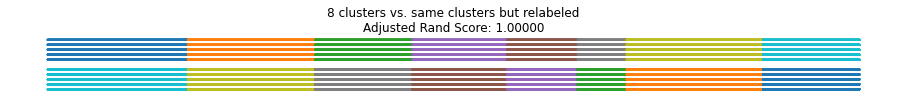

In [ ]:
compare(results.loc[8, 0].y, 7 - results.loc[8, 0].y, '8 clusters vs. same clusters but relabeled')

- Now we know the target label does not matter. Also a sanity check to verify the exact same clusters recieve a perfect score

## Comparison to random clusters

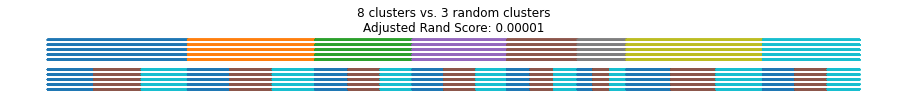

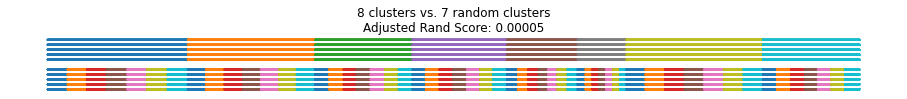

In [ ]:
rng = np.random.default_rng()
compare(results.loc[8, 0].y, rng.integers(0, 3, len(data)), '8 clusters vs. 3 random clusters')
compare(results.loc[8, 0].y, rng.integers(0, 7, len(data)), '8 clusters vs. 7 random clusters')

- Comparison with random integers produces a ARS of ~0

## 8 Clusters to 7, but two clusters are joined

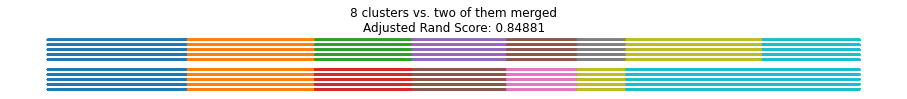

In [ ]:
compare(results.loc[8, 0].y, results.loc[8, 0].y.clip(0, 6), '8 clusters vs. two of them merged')

- An 8 numbered clustering where two of the clusters are merged to produce 7 clusters, compared with 7 clustered gives ~0.85

## Comparing effect of seed

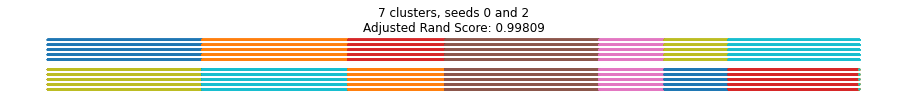

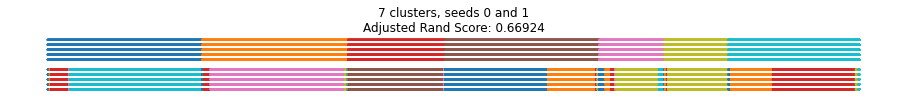

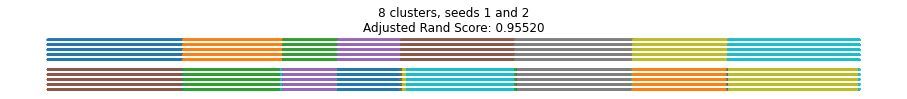

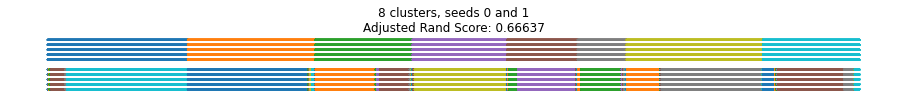

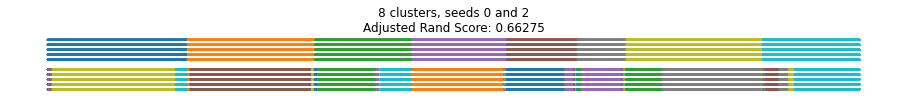

In [ ]:
compare(results.loc[7, 0].y, results.loc[7, 2].y, '7 clusters, seeds 0 and 2')
compare(results.loc[7, 0].y, results.loc[7, 1].y, '7 clusters, seeds 0 and 1')
compare(results.loc[8, 1].y, results.loc[8, 2].y, '8 clusters, seeds 1 and 2')
compare(results.loc[8, 0].y, results.loc[8, 1].y, '8 clusters, seeds 0 and 1')
compare(results.loc[8, 0].y, results.loc[8, 2].y, '8 clusters, seeds 0 and 2')

- This is a peculiar result... seeds 0 and 2 with seven clusters recieved a nearly perfect score whilst seeds 1, 2 got 0.67. The opposite happens for eight clusters: seeds 1 and 2 got a great score while 0 and 2 did not do well

## 7 clusters compared to 8

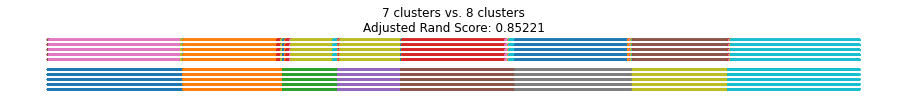

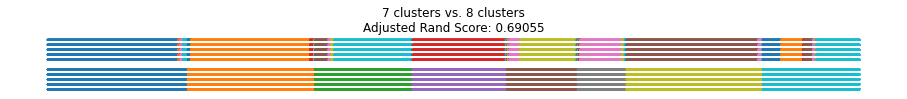

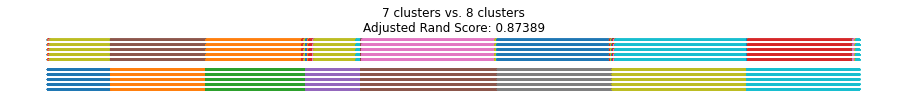

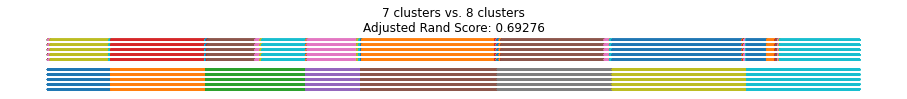

In [ ]:
compare(results.loc[7, 1].y, results.loc[8, 1].y, '7 clusters vs. 8 clusters')
compare(results.loc[7, 0].y, results.loc[8, 0].y, '7 clusters vs. 8 clusters')
compare(results.loc[7, 1].y, results.loc[8, 2].y, '7 clusters vs. 8 clusters')
compare(results.loc[7, 0].y, results.loc[8, 2].y, '7 clusters vs. 8 clusters')

- fi the test data has 8 clusters and our has seven we can expect a range from ~0.6-0.9

## 7 clusters compared to 10

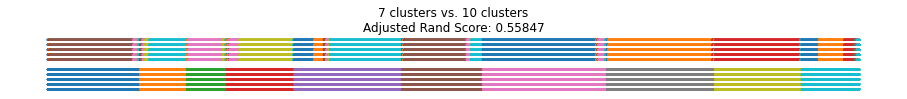

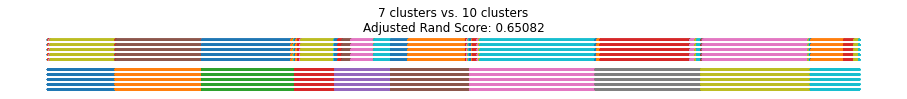

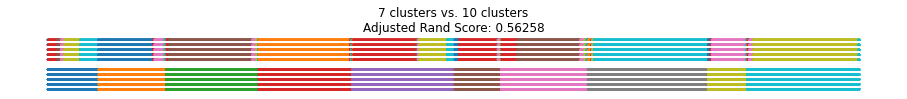

In [ ]:
compare(results.loc[7, 0].y, results.loc[10, 1].y, '7 clusters vs. 10 clusters')
compare(results.loc[7, 1].y, results.loc[10, 2].y, '7 clusters vs. 10 clusters')
compare(results.loc[7, 2].y, results.loc[10, 0].y, '7 clusters vs. 10 clusters')

- This means that if the testing data has seven clusters and we submit 10, the best we can hope for is basically 0.65

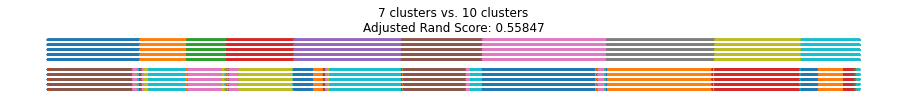

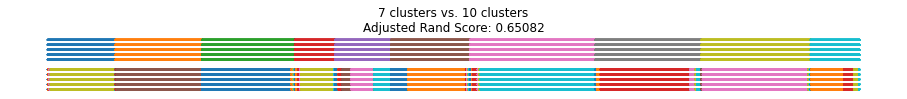

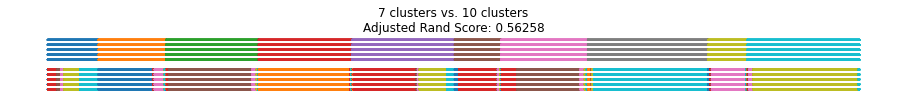

In [ ]:
compare(results.loc[10, 1].y, results.loc[7, 0].y, '7 clusters vs. 10 clusters')
compare(results.loc[10, 2].y, results.loc[7, 1].y, '7 clusters vs. 10 clusters')
compare(results.loc[10, 0].y, results.loc[7, 2].y, '7 clusters vs. 10 clusters')